In [1]:
using NetCDF, PyPlot, BitInformation
using TranscodingStreams, CodecZstd
using Dates

In [2]:
ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [3]:
path= "/network/aopp/chaos/pred/kloewer/esowc/satellite/viirs_I_20210513_t2342292.nc"
ncfile = NetCDF.open(path)
I04 = ncfile.vars["I04"][2800:6500,500:5500]
I05 = ncfile.vars["I05"][2800:6500,500:5500]
start_time = ncfile.vars["I04"].atts["start_time"];

In [4]:
# Information
bi04 = bitinformation(I04)
bi05 = bitinformation(I05);

In [5]:
# filter
bi04filt = [if b > maximum(bi04[25:end]) b else 0.0 end for b in bi04]
bi05filt = [if b > maximum(bi05[25:end]) b else 0.0 end for b in bi05]

p = 0.99
keepbits04 = argmax(cumsum(bi04filt)/sum(bi04filt) .>= p) - 9
keepbits05 = argmax(cumsum(bi05filt)/sum(bi05filt) .>= p) - 9

9

In [6]:
keepbits04

9

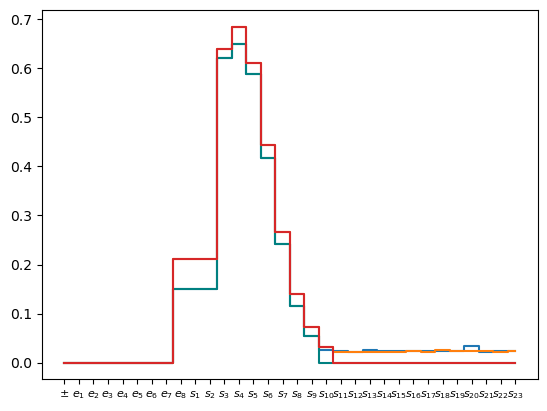

In [7]:
plot(1:32,bi04,"C0",ds="steps-mid")
plot(1:32,bi04filt,"teal",ds="steps-mid")

plot(1:32,bi05,"C1",ds="steps-mid")
plot(1:32,bi05filt,"C3",ds="steps-mid")

xticks(1:32,vcat("±",[L"e_%$i" for i in 1:8],                           # label sign, exponent and significant bits
        [L"s_{%$i}" for i in 1:23]),fontsize=8);

# Compression

In [8]:
I04r = round(I04,keepbits04)
I05r = round(I05,keepbits05);

In [9]:
comp_fac04 = 2*sizeof(I04)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,vec(I04r)))))

13.690892901557902

In [10]:
comp_fac05 = 2*sizeof(I05)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,vec(I05r)))))

14.234255494170881

# Plotting

In [11]:
using ColorSchemes, Statistics, StatsBase
cmap = ColorMap(ColorSchemes.roma.colors).reversed()

In [12]:
vmin4,vmax4 = quantile(vec(I04),[0.01,0.99])
vmin5,vmax5 = quantile(vec(I05),[0.01,0.99])
vmin = min(vmin4,vmin5)
vmax = max(vmax4,vmax5)

293.4291076660156

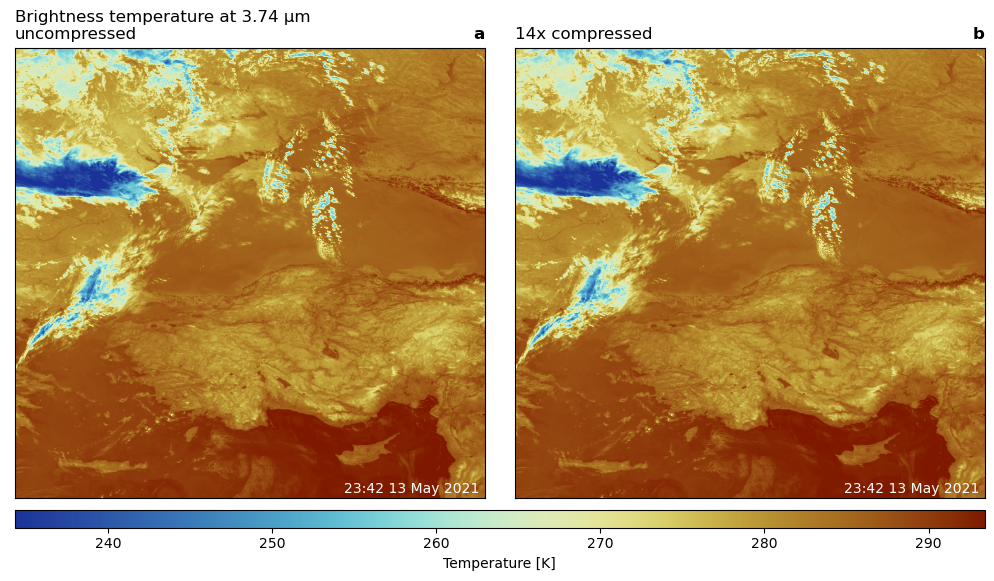

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [13]:
fig = figure(figsize=(10,6))
ax1 = fig.add_axes(rect=[0.02,0.15,0.47,0.75])
ax2 = fig.add_axes(rect=[0.52,0.15,0.47,0.75])
axs = (ax1,ax2)

pos1 = ax1.get_position()
pos2 = ax2.get_position()
cax = fig.add_axes([pos1.x0,pos1.y0-0.05,pos2.x1-pos1.x0,0.03])

q = axs[1].imshow(I04',aspect="auto";cmap,vmin,vmax)
axs[2].imshow(I04r',aspect="auto";cmap,vmin,vmax)
cbar = colorbar(q,cax=cax,orientation="horizontal",label="Temperature [K]")

axs[1].set_xticks([])
axs[1].set_yticks([])

for (iax,ax) in enumerate(axs)
    ax.set_title(string(Char(iax+96)),loc="right",fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
end

axs[1].set_title("Brightness temperature at 3.74 µm\nuncompressed",loc="left")
axs[2].set_title("$(round(Int,comp_fac04))x compressed",loc="left")

axs[1].text(0.7,0.01,"$(start_time[12:16]) "*
    Dates.format(Dates.Date(start_time[1:10]),"d u yyyy"),
    transform=axs[1].transAxes,color="w")
axs[2].text(0.7,0.01,"$(start_time[12:16]) "*
    Dates.format(Dates.Date(start_time[1:10]),"d u yyyy"),
    transform=axs[2].transAxes,color="w")

tight_layout()
# savefig("brightness_temp.png",dpi=200)